In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader, TensorDataset
import matplotlib.pyplot as plt

import numpy as np
import gzip

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# Mount files
from google.colab import drive
drive.mount('/content/drive')

# Loading images and labels from .gz files
def load_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        # First 16 bytes are metadata about the file
        f.read(16)
        # The remaining bytes are the image pixels
        buf = f.read()
        images = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        # Reshape into [number of images, height, width]
        images = images.reshape(-1, 28, 28) / 255.0  # normalize to [0, 1] range
    return torch.tensor(images).unsqueeze(1)  # add channel dimension (1, 28, 28)

def load_mnist_labels(filename):
    with gzip.open(filename, 'rb') as f:
        # First 8 bytes are metadata about the file
        f.read(8)
        # The remaining bytes are the label data
        buf = f.read()
        labels = np.frombuffer(buf, dtype=np.uint8)
    return torch.tensor(labels)

# Load training data
train_images = load_mnist_images('/content/drive/MyDrive/Colab Notebooks/data/train-images-idx3-ubyte.gz')
train_labels = load_mnist_labels('/content/drive/MyDrive/Colab Notebooks/data/train-labels-idx1-ubyte.gz')

# Load test data
test_images = load_mnist_images('/content/drive/MyDrive/Colab Notebooks/data/test-images-idx3-ubyte.gz')
test_labels = load_mnist_labels('/content/drive/MyDrive/Colab Notebooks/data/test-labels-idx1-ubyte.gz')

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images, test_labels)

# Split training dataset into training set and validation set (80, 20)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Setting up models

In [ ]:
"""
1. Batchnorm after RELU
2. One dropout after fc2
"""

class LeNet5_BN_After_Relu_One_DropOut(nn.Module):
    def __init__(self, dropout=False, batch_norm=False, dropout_p = 0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        self.dropout = nn.Dropout(p=dropout_p) if dropout else nn.Identity()
        self.batch_norm1 = nn.BatchNorm2d(6) if batch_norm else nn.Identity()
        self.batch_norm2 = nn.BatchNorm2d(16) if batch_norm else nn.Identity()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.batch_norm1(x) # no-op if batch_norm is False
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = self.batch_norm2(x) # no-op if batch_norm is False
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16*4*4) # can be replaced with torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x) # no-op if dropout is False
        x = self.fc3(x)
        return x

In [ ]:
"""
1. Batchnorm before RELU, instead of after
2. Two dropouts: once after fc1 + once after fc2
"""

class LeNet5_BN_Before_Relu_Two_DropOut(nn.Module):
    def __init__(self, dropout=False, batch_norm=False, dropout_p = 0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        self.dropout = nn.Dropout(p=dropout_p) if dropout else nn.Identity()
        self.batch_norm1 = nn.BatchNorm2d(6) if batch_norm else nn.Identity()
        self.batch_norm2 = nn.BatchNorm2d(16) if batch_norm else nn.Identity()

    def forward(self, x):
        # First layer + batchnorm + pooling
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        # Second layer + batchnorm + pooling
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        # Flatten for FC layers
        x = x.view(-1, 16*4*4)

        # FC layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
"""
BEST
1. Batchnorm before RELU, instead of after
2. One dropout: once after fc2
"""

class LeNet5_BN_Before_Relu_One_DropOut(nn.Module):
    def __init__(self, dropout=False, batch_norm=False, dropout_p = 0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        self.dropout = nn.Dropout(p=dropout_p) if dropout else nn.Identity()
        self.batch_norm1 = nn.BatchNorm2d(6) if batch_norm else nn.Identity()
        self.batch_norm2 = nn.BatchNorm2d(16) if batch_norm else nn.Identity()

    def forward(self, x):
        # First layer + batchnorm + pooling
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        # Second layer + batchnorm + pooling
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        # Flatten for FC layers
        x = x.view(-1, 16*4*4)

        # FC layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
def train_model(model, loss_fn, optimizer, epochs=10, measure_without_dropout=False):
    best_val_accuracy = 0.0
    best_model_state = None
    train_accuracies, val_accuracies, test_accuracies = [], [], []

    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            # Compute the loss and its gradients
            loss = loss_fn(outputs, labels)
            loss.backward()
            # Adjust learning weights
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total

        # for model using dropout regularization, go over the training set and measure the accuracy wo dropout
        if measure_without_dropout:
            train_accuracy = evaluate_model(model, train_loader)
            model.train()  # set back to train=true

        train_accuracies.append(train_accuracy)

        # Validation phase
        val_accuracy = evaluate_model(model, val_loader)
        val_accuracies.append(val_accuracy)

        # test the model for each epoch
        test_accuracy = evaluate_model(model, test_loader)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Train Accuracy: {train_accuracy}%, Validation Accuracy: {val_accuracy}%, Test Accuracy: {test_accuracy}%")

        # Save the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_state = model.state_dict()

    # Load the best model state
    model.load_state_dict(best_model_state)
    return model, train_accuracies, val_accuracies, test_accuracies

def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    # Disable gradient computation and reduce memory consumption
    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Train different models

In [ ]:
# Define loss function and learning rate
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3

In [ ]:
model_no_reg = LeNet5_BN_Before_Relu_One_DropOut().to(device)
optimizer = optim.Adam(model_no_reg.parameters(), lr=learning_rate)

model_no_reg_optimized, train_accuracies, val_accuracies, test_accuracies = train_model(model_no_reg, loss_fn, optimizer)
test_accuracies_no_reg = evaluate_model(model_no_reg_optimized, test_loader)
print(test_accuracies_no_reg)

In [ ]:
# Results for TWO dropouts with 0.3 probability
model_two_dropout_30 = LeNet5_BN_Before_Relu_Two_DropOut(dropout=True, dropout_p=0.3).to(device)
optimizer_dropout = optim.Adam(model_two_dropout_30.parameters(), lr=learning_rate)

model_two_dropout_30_optimized, train_accuracies_two_dropout_30, val_accuracies_two_dropout_30, test_accuracies_two_dropout_30 = train_model(model_two_dropout_30, loss_fn, optimizer_dropout, measure_without_dropout=True)
test_accuracies_two_dropout_30 = evaluate_model(model_two_dropout_30_optimized, test_loader)
print(test_accuracies_two_dropout_30)

In [ ]:
# Results for TWO dropouts with 0.5 probability
model_two_dropout_50 = LeNet5_BN_Before_Relu_Two_DropOut(dropout=True, dropout_p=0.5).to(device)
optimizer_dropout = optim.Adam(model_two_dropout_50.parameters(), lr=learning_rate)

model_two_dropout_50_optimized, train_accuracies_two_dropout_50, val_accuracies_two_dropout_50, test_accuracies_two_dropout_50 = train_model(model_two_dropout_30, loss_fn, optimizer_dropout, measure_without_dropout=True)
test_accuracies_two_dropout_50 = evaluate_model(model_two_dropout_50_optimized, test_loader)
print(test_accuracies_two_dropout_50)

In [ ]:
# Results for TWO dropouts with 0.7 probability
model_two_dropout_70 = LeNet5_BN_Before_Relu_Two_DropOut(dropout=True, dropout_p=0.7).to(device)
optimizer_dropout = optim.Adam(model_two_dropout_70.parameters(), lr=learning_rate)

model_two_dropout_70_optimized, train_accuracies_two_dropout_70, val_accuracies_two_dropout_70, test_accuracies_two_dropout_70 = train_model(model_two_dropout_30, loss_fn, optimizer_dropout, measure_without_dropout=True)
test_accuracies_two_dropout_70 = evaluate_model(model_two_dropout_70_optimized, test_loader)
print(test_accuracies_two_dropout_70)

In [ ]:
# Results for ONE dropout
model_one_dropout_30 = LeNet5_BN_After_Relu_One_DropOut(dropout=True, dropout_p=0.3).to(device)
optimizer_dropout = optim.Adam(model_one_dropout_30.parameters(), lr=learning_rate)

model_one_dropout_30_optimized, train_accuracies_one_dropout_30, val_accuracies_one_dropout_30, test_accuracies_one_dropout_30 = train_model(model_one_dropout_30, loss_fn, optimizer_dropout, measure_without_dropout=True)
test_accuracies_one_dropout_30 = evaluate_model(model_one_dropout_30_optimized, test_loader)
print(test_accuracies_one_dropout_30)

In [ ]:
# Results for ONE dropout
model_one_dropout_50 = LeNet5_BN_After_Relu_One_DropOut(dropout=True, dropout_p=0.5).to(device)
optimizer_dropout = optim.Adam(model_one_dropout_50.parameters(), lr=learning_rate)

model_one_dropout_50_optimized, train_accuracies_one_dropout_50, val_accuracies_one_dropout_50, test_accuracies_one_dropout_50 = train_model(model_one_dropout_50, loss_fn, optimizer_dropout, measure_without_dropout=True)
test_accuracies_one_dropout_50 = evaluate_model(model_one_dropout_50_optimized, test_loader)
print(test_accuracies_one_dropout_50)

In [ ]:
# Results for batch-norm AFTER relu
model_batchnorm_after_relu = LeNet5_BN_After_Relu_One_DropOut(batch_norm=True).to(device)
optimizer_batchnorm_after_relu = optim.Adam(model_batchnorm_after_relu.parameters(), lr=learning_rate)

model_batchnorm_after_relu_optimized, train_accuracies_batchnorm_after_relu, val_accuracies_batchnorm_after_relu, test_accuracies_batchnorm_after_relu = train_model(model_batchnorm_after_relu, loss_fn, optimizer_batchnorm_after_relu)
test_accuracies_batchnorm_after_relu = evaluate_model(model_batchnorm_after_relu_optimized, test_loader)
print(test_accuracies_batchnorm_after_relu)


In [ ]:
# Results for batch-norm BEFORE relu
model_batchnorm_before_relu = LeNet5_BN_Before_Relu_One_DropOut(batch_norm=True).to(device)
optimizer_batchnorm_before_relu = optim.Adam(model_batchnorm_before_relu.parameters(), lr=learning_rate)

model_batchnorm_before_relu_optimized, train_accuracies_batchnorm_before_relu, val_accuracies_batchnorm_before_relu, test_accuracies_batchnorm_before_relu = train_model(model_batchnorm_before_relu, loss_fn, optimizer_batchnorm_after_relu)
test_accuracies_batchnorm_before_relu = evaluate_model(model_batchnorm_after_relu_optimized, test_loader)
print(test_accuracies_batchnorm_before_relu)

# Comments: batch-norm works best done before relu

In [ ]:
for val in [0.01, 0.001, 0.0001]:
    model_weight_decay = LeNet5_BN_Before_Relu_One_DropOut().to(device)
    optimizer_weight_decay = optim.Adam(model_weight_decay.parameters(), lr=learning_rate, weight_decay=val)

    model_weight_decay_optimized, train_accuracies_weight_decay, val_accuracies_weight_decay, test_accuracies_weight_decay = train_model(model_weight_decay, loss_fn, optimizer_weight_decay)
    test_accuracies_weight_decay = evaluate_model(model_weight_decay_optimized, test_loader)
    print(f"Weight decay: {val}, Test accuracy: {test_accuracies_weight_decay} using Adam optimizer")

In [ ]:
for val in [0.01, 0.001, 0.0001]:
    model_weight_decay = LeNet5_BN_Before_Relu_One_DropOut().to(device)
    optimizer_weight_decay = optim.AdamW(model_weight_decay.parameters(), lr=learning_rate, weight_decay=val)

    model_weight_decay_optimized, train_accuracies_weight_decay, val_accuracies_weight_decay, test_accuracies_weight_decay = train_model(model_weight_decay, loss_fn, optimizer_weight_decay)
    test_accuracies_weight_decay = evaluate_model(model_weight_decay_optimized, test_loader)
    print(f"Weight decay: {val}, Test accuracy: {test_accuracies_weight_decay} using AdamW optimizer")

# Plotting graphs

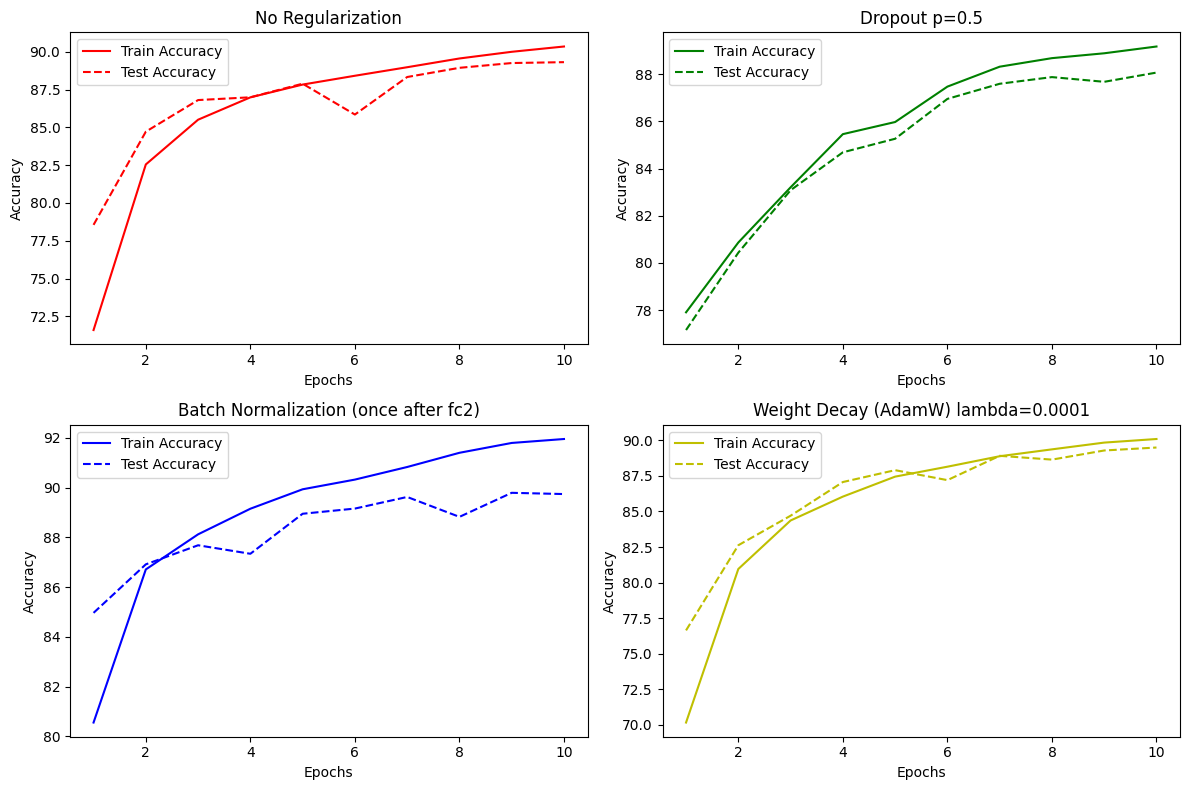

In [ ]:
epochs = range(1, 11)

def plot_accuracy(epochs, train_accuracies, test_accuracies, title, color):
    plt.plot(epochs, train_accuracies, color=color, label='Train Accuracy')
    plt.plot(epochs, test_accuracies, color=color, linestyle='--', label='Test Accuracy')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

# Plotting convergence graphs
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plot_accuracy(epochs, train_accuracies, test_accuracies, 'No Regularization', color='r')

plt.subplot(2, 2, 2)
plot_accuracy(epochs, train_accuracies_two_dropout_50, test_accuracies_two_dropout_50, 'Dropout p=0.5', color='g')

plt.subplot(2, 2, 3)
plot_accuracy(epochs, train_accuracies_batchnorm_before_relu, test_accuracies_batchnorm_before_relu, 'Batch Normalization (once after fc2)', color='b')

plt.subplot(2, 2, 4)
plot_accuracy(epochs, train_accuracies_weight_decay, test_accuracies_weight_decay, 'Weight Decay (AdamW) lambda=0.0001', color='y')

plt.tight_layout()
plt.show()